# Physics-Informed Neural Network (PINN) in Julia

This is a simple showcase of how PINNs can learn the solution to (Partial) Differential Equations without labelled data by leveraging automatic differentation to train on a residuum loss of the boundary value problem.

We will consider the 1D Poisson equation
$$
\begin{cases}
\frac{\partial^2 u}{\partial x^2} &= - f(x), \qquad & x \in \Omega = (0, 1)
\\
u(0) &= 0 = u(1)
\end{cases}
$$

For $f(x) = \sin(\pi x)$, the analytical solution is $\hat{u}(x) = \frac{1}{\pi^2} \sin(\pi x)$. We aim to train a shallow neural network to learn the mapping $x \mapsto u$.

This can be done by chosing collocation points, i.e., random points within the domain at which we enfore the PDE. A difference of the neural network against this underlying description will constitute to the loss. Additionally, we will also penalize if the network does not obey the homogeneous Dirichlet boundary conditions. As such our loss is

$$
\mathcal{L} = \alpha_{int} \frac{1}{2N} \sum_{i=1}^N \left( \frac{\partial^2 u}{\partial x^2}\bigg|_{x_i} + f(x_i)  \right)^2  + \alpha_{bc} \frac{1}{2 \cdot 2} \left( u(0)^2 + u(1)^2 \right)
$$

with hyperparameters to weigh the two components of the loss. Our neural network is parameterized by its weights and biases. We can backprop from this loss into the parameter space to obtain a gradient estimate which guides a gradient-based optimizer (here we will use ADAM).

**Julia's reverse-mode automatic differentiation ecosystem, as of now, does not properly support higher-order autodiff**. However, this is crucial, because ultimately we need three autodiff passes, two to get the second derivative within the loss formulation and another one to obtain a gradient estimate in the parameter space.

## Employed architecture

This intro follows the work of Lagaris et al. ([https://arxiv.org/abs/physics/9705023](https://arxiv.org/abs/physics/9705023)) that use a neural network with **one hidden layer**. By the universal approximation theorem, this is sufficient to capture (almost) any function. Hence, given the hidden layer is chosen large enough, it should also be possible to approximate the solution to the PDE. The forward pass of the network becomes

$$
u = v^T \sigma.(w x + b)
$$

We assume our network to be a scalar-to-scalar map, hence

$$
x \in \R, w \in \R^h, b \in \R^h, v \in \R^h, u \in \R
$$

with $h$ being the size of the hidden dimension.

### Analytical Input-Output derivative

**Our goal is to reduce to only one application of the Julia reverse-mode autodiff engine; the pullback from loss to parameter space.** As such, we want to find hand-coded derivatives for the network architecture in their input-output relation.

We can derive this simple shallow network to get

$$
\begin{aligned}
\frac{\partial u}{\partial x} &= (v \odot w)^T \sigma'(w x + b)
\\
\frac{\partial^2 u}{\partial x^2} &= (v \odot w.^2)^T \sigma''(w x + b)
\\
\frac{\partial^l u}{\partial x^l} &= (v \odot w.^l)^T \sigma^{(l)}(w x + b)
\end{aligned}
$$

### The batched case

For all practical applications, we want to query our network batched, i.e., for multiple inputs at the same time. Following the Julia convention, we will therefore the denote the collection of inputs as $x \in \R^{1 \times N}$ and the collection of outputs as $u \in \R^{1 \times N}$. As such, the forward pass becomes

$$
u = V \cdot \sigma.(W \cdot x .+ b)
$$

with the sizes

$$
x \in \R^{1 \times N}, W \in \R^{h, 1}, b \in \R^h, V \in \R^{1, h}, u \in \R^{1 \times N}
$$

### Properties of the sigmoid

Its higher derivatives can be expressed using the primal output

$$
\begin{aligned}
\sigma(x) &= \frac{1}{1 + e^{-x}}
\\
\sigma' &= \sigma (1 - \sigma)
\\
\sigma'' &= \sigma (1 - \sigma) \left( 1- 2\sigma \right) = \sigma' \left( 1- 2\sigma \right)
\end{aligned}
$$



In [13]:
using Optimisers, Zygote, Plots, Random, Distributions
using FiniteDiff

In [14]:
using ReverseDiff

In [41]:
SEED = 42
N_collocation_points = 50
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 20_000
BC_LOSS_WEIGHT = 100.0

100.0

In [42]:
rhs_function(x) = sin(π * x)
analytical_solution(x) = sin(π * x) / π^2

analytical_solution (generic function with 1 method)

In [43]:
rng = MersenneTwister(SEED)

MersenneTwister(42)

In [44]:
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [45]:
# Initialize the weights according to the Xavier Glorot initializer
uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
W = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    HIDDEN_DEPTH,
    1,
)
V = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    1,
    HIDDEN_DEPTH,
)
b = zeros(HIDDEN_DEPTH)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [46]:
parameters = (; W, V, b)

(W = [0.10276961030370574; -0.21229892796353997; … ; 0.10161926776805669; 0.04541946666780078;;], V = [-0.1777197430255085 -0.17909130185688604 … 0.057382630868962226 -0.05530028611229676], b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [47]:
network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)

network_forward (generic function with 1 method)

In [48]:
x_line = reshape(collect(range(0.0f0, stop=1.0f0, length=100)), (1, 100))

1×100 Matrix{Float32}:
 0.0  0.010101  0.020202  0.030303  …  0.969697  0.979798  0.989899  1.0

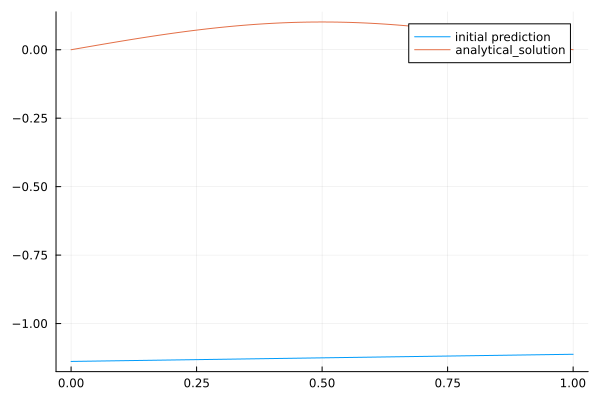

In [49]:
# Plot initial prediction of the network (together with the analytical solution)
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")

In [50]:
# Obtener el valor de εmachine para Float64
εmachine = eps(Float64)

# Definir los valores de ε
ε1 = εmachine^(1/3)
ε2 = εmachine^(1/4)
ε3 = εmachine^(1/5)

0.000740095979741405

In [51]:
function network_forward_wrapper(x)
    return network_forward(x, parameters)[1]
end

function network_output_and_first_two_derivatives(x, p)
    f(x)=(p.V * sigmoid.(p.W * x .+ p.b))[1]
    activated_state = sigmoid.(p.W * x .+ p.b)
    sigmoid_prime = activated_state .* (1.0 .- activated_state)
    sigmoid_double_prime = sigmoid_prime .* (1.0 .- 2.0 .* activated_state)

    output = p.V * activated_state
    first_derivative = (f.(x_line .+ ε1) - f.(x_line .- ε1)) / (2 * ε1)#(p.V .* p.W') * sigmoid_prime
    #first_derivative = TaylorDiff.derivative.(f, x, Val(1))
    second_derivative = (f.(x .+ ε2) .- 2 .* f.(x) .+ f.(x .- ε2)) / (ε2^2)#(p.V .* p.W' .* p.W') * sigmoid_double_prime#(f.(x_line .+ ε2) .- 2 .* f.(x_line) .+ f.(x_line .- ε2)) / (ε2^2)#(p.V .* p.W' .* p.W') * sigmoid_double_prime
    #second_derivative = TaylorDiff.derivative.(f, x, Val(2))
    #second_derivative = Float64.(Zygote.gradient(x -> sum(f(x)), x)[1])

    return output, first_derivative, second_derivative
end

network_output_and_first_two_derivatives (generic function with 1 method)

In [52]:
interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))

1×50 Matrix{Float64}:
 0.0357248  0.473918  0.441437  0.841032  …  0.872303  0.680714  0.776496

In [53]:
boundary_collocation_points = [0.0 1.0]

1×2 Matrix{Float64}:
 0.0  1.0

In [54]:
function loss_forward(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(
        interior_collocation_points,
        p,
    )

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)

    interior_loss = 0.5 * mean(interior_residuals.^2)

    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0

    boundary_loss = 0.5 * mean(boundary_residuals.^2)

    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss

    return total_loss
end

loss_forward (generic function with 1 method)

In [55]:
opt = Adam(LEARNING_RATE)

Adam(0.001, (0.9, 0.999), 1.0e-8)

In [61]:
opt_state = Optimisers.setup(opt, parameters)
loss_history = []
for i in 1:N_EPOCHS
    loss, back = Zygote.pullback(loss_forward, parameters)
    push!(loss_history, loss)
    grad, = back(1.0)
    opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
    if i % 100 == 0
        println("Epoch: $i, Loss: $loss")
    end
end

Epoch: 100, Loss: 0.0007899116643804308
Epoch: 200, Loss: 0.000784011212018186
Epoch: 300, Loss: 0.0007809763660790027
Epoch: 400, Loss: 0.0007775140562839714
Epoch: 500, Loss: 0.0007735980737139033
Epoch: 600, Loss: 0.0007692099611698776
Epoch: 700, Loss: 0.000764352320521531
Epoch: 800, Loss: 0.000759032562747872
Epoch: 900, Loss: 0.000753263280798219
Epoch: 1000, Loss: 0.0007470536474045446
Epoch: 1100, Loss: 0.0007404131076573977
Epoch: 1200, Loss: 0.0007333531170801033
Epoch: 1300, Loss: 0.0007258835838218651
Epoch: 1400, Loss: 0.000718016486326569
Epoch: 1500, Loss: 0.0007097677065962478
Epoch: 1600, Loss: 0.0007011540652323978
Epoch: 1700, Loss: 0.0006921951932198012
Epoch: 1800, Loss: 0.0006829156788645686
Epoch: 1900, Loss: 0.0025925148162703505
Epoch: 2000, Loss: 0.0006659256193321427
Epoch: 2100, Loss: 0.0006582603961503629
Epoch: 2200, Loss: 0.0006503736617574152
Epoch: 2300, Loss: 0.0006422853948449256
Epoch: 2400, Loss: 0.0012552045757750663
Epoch: 2500, Loss: 0.000627657

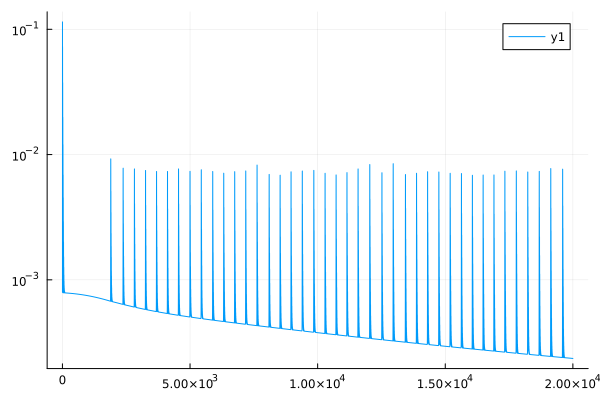

In [62]:
plot(loss_history, yscale=:log10)

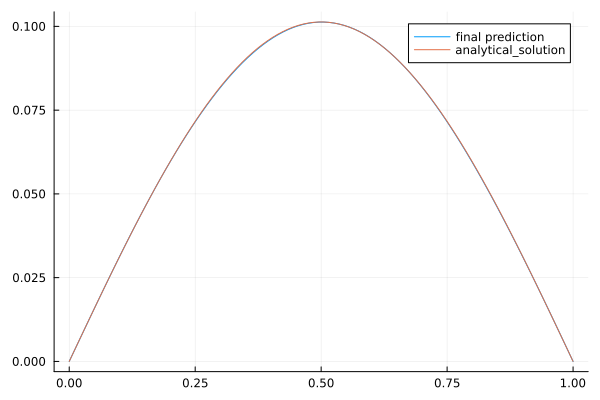

In [63]:
plot(x_line[:], network_forward(x_line, parameters)[:], label="final prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")